In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import sparse, stats
from sklearn.model_selection import KFold

from pynba import possessions_from_file, use_blackontrans_style

%load_ext pyinstrument

use_blackontrans_style()
league = "nba"
years = [2018, 2019, 2020, 2021, 2022]
season_type = "Regular Season"

possessions = pd.concat([possessions_from_file(league, year, season_type) for year in years])
nba_player_ids = pd.read_csv("/home/jupyter/nba/data/NBA_Player_IDs.csv", encoding_errors="ignore")
player_id_mapping = {
    int(player_id): player_name
    for player_name, player_id
    in zip(nba_player_ids["NBAName"], nba_player_ids["NBAID"])
    if not pd.isna(player_id)
}

In [2]:
POSS_COLS = [
    "off_player0", "off_player1", "off_player2", "off_player3", "off_player4", 
    "def_player0", "def_player1", "def_player2", "def_player3", "def_player4",
    "points_scored", "possession_num"
]


def calc_rapm(possessions, off_prior, def_prior):
    var = _calc_variance(possessions)
    stints = _calc_stints(possessions)
    player_ids = _calc_player_ids(stints)
    n_players = player_ids.shape[0]
    X = _calc_X(stints, player_ids, n_players)
    w = _calc_w(stints)
    XT_W = _calc_XT_W(X, w)
    y = _calc_y(stints)
    G = _calc_G(var, off_prior, def_prior, n_players)
    A, b = _calc_A_b(X, XT_W, G, y)
    x = _solve_for_x(A, b)
    
    rapm, off_rapm, def_rapm = _calc_rapm(x, n_players)
    rapm_std, off_rapm_std, def_rapm_std = _calc_stds(X, x, y, w, A, n_players)
    off_poss, def_poss, raw_pm, off_raw_pm, def_raw_pm = _calc_raw_stats(XT_W, b, n_players)
    names = _calc_names(player_ids)
    return pd.DataFrame({
        "name": names,
        "rapm": rapm,
        "off_rapm": off_rapm,
        "def_rapm": def_rapm,
        "rapm_std": rapm_std,
        "off_rapm_std": off_rapm_std,
        "def_rapm_std": def_rapm_std,
        "off_poss": off_poss,
        "def_poss": def_poss,
        "raw_pm": raw_pm,
        "off_raw_pm": off_raw_pm,
        "def_raw_pm": def_raw_pm,
    }, index=player_ids)


def _calc_player_ids(stints):
    cols = [f"off_player{ind}" for ind in range(5)] + [f"def_player{ind}" for ind in range(5)]
    return np.unique(stints.loc[:, cols])


def _calc_stints(possessions):
    poss = possessions.loc[:, POSS_COLS]
    off_player_ids = poss[[f"off_player{ind}" for ind in range(5)]].to_numpy()
    off_player_ids.sort(1)
    poss["off_player_ids"] = [row.tobytes() for row in off_player_ids]
    def_player_ids = poss[[f"def_player{ind}" for ind in range(5)]].to_numpy()
    def_player_ids.sort(1)
    poss["def_player_ids"] = [row.tobytes() for row in def_player_ids]
    return poss.groupby(by=["off_player_ids", "def_player_ids"]).agg(
        {
            "off_player0": "first",
            "off_player1": "first",
            "off_player2": "first",
            "off_player3": "first",
            "off_player4": "first",
            "def_player0": "first",
            "def_player1": "first",
            "def_player2": "first",
            "def_player3": "first",
            "def_player4": "first",
            "points_scored": "sum",
            "possession_num": "count",
        }
    ).reset_index()


def _calc_X(stints, player_ids, n_players):
    off_player_ids = stints.loc[:, [f"off_player{ind}" for ind in range(5)]].to_numpy()
    def_player_ids = stints.loc[:, [f"def_player{ind}" for ind in range(5)]].to_numpy()
    n_stints = stints.shape[0]

    X = sparse.lil_matrix((2 * n_players, n_stints))
    for ind, player_id in enumerate(player_ids):
        X[ind, :] = (player_id == off_player_ids).any(1)
        X[n_players + ind, :] = (player_id == def_player_ids).any(1)

    return X.T.tocsr().astype("float64")


def _calc_y(stints):
    mu = stints["points_scored"].sum() / stints["possession_num"].sum()
    y = (stints["points_scored"] / stints["possession_num"] - mu) * 100
    return y.to_numpy().astype("float64")


def _calc_w(stints):
    return stints["possession_num"].to_numpy().astype("float64").reshape(-1, 1)


def _calc_XT_W(X, w):
    return X.multiply(w).T.tocsr()


def _calc_G(var, off_prior, def_prior, n_players):
    return sparse.diags([var / off_prior ** 2] * n_players + [var / def_prior ** 2] * n_players)


def _calc_A_b(X, XT_W, G, y):
    A = XT_W.dot(X) + G
    b = XT_W.dot(y)
    return A, b


def _calc_variance(possessions):
    counts = possessions["points_scored"].value_counts()
    p = counts / possessions.shape[0]
    eff = counts.index * 100
    return ((eff ** 2) * p).sum() - (eff * p).sum() ** 2


def _solve_for_x(A, b):
    return sparse.linalg.spsolve(A, b)


def _calc_rapm(x, n_players):
    off_rapm, def_rapm = x[:n_players], -x[n_players:]
    rapm = off_rapm + def_rapm
    return rapm, off_rapm, def_rapm


def _calc_stds(X, x, y, w, A, n_players):
    r = y - X.dot(x)
    rss = (r * w.reshape(-1)).dot(r)
    sigma2 = rss / (X.shape[0] - X.shape[1])
    cov_x = sigma2 * sparse.linalg.inv(A.tocsc())
    x_var = cov_x.diagonal()
    off_def_cov = cov_x.diagonal(n_players)
    off_rapm_var, def_rapm_var = x_var[:n_players], x_var[n_players:]
    rapm_var = off_rapm_var + def_rapm_var + 2 * off_def_cov
    return np.sqrt(rapm_var), np.sqrt(off_rapm_var), np.sqrt(def_rapm_var)


def _calc_raw_stats(XT_W, b, n_players):
    poss = np.asarray(XT_W.sum(1)).reshape(-1).astype(int)
    off_poss, def_poss = poss[:n_players], poss[n_players:]
    raw_pms = b / poss
    off_raw_pm, def_raw_pm = raw_pms[:n_players], -raw_pms[n_players:]
    raw_pm = off_raw_pm + def_raw_pm
    return off_poss, def_poss, raw_pm, off_raw_pm, def_raw_pm


def _calc_names(player_ids):
    return [player_id_mapping.get(player_id, "n/a") for player_id in player_ids]

## Optimizing the prior using pattern search

Cutting the search space in half takes 1.5 evaluations (we're assuming the search space is convex).

In [3]:
def optimize_rapm(possessions, rounds, off_prior_range, def_prior_range):
    var = _calc_variance(possessions)
    stints = _calc_stints(possessions)
    player_ids = _calc_player_ids(stints)
    n_players = player_ids.shape[0]
    X = _calc_X(stints, player_ids, n_players)
    w = _calc_w(stints)
    XT_W = _calc_XT_W(X, w)
    y = _calc_y(stints)
    std = _calc_resid_std(var, stints)
    def objective(off_prior, def_prior):
        return _score_rapm(X, XT_W, y, std, var, n_players, off_prior, def_prior)
    return _pattern_search(objective, rounds, off_prior_range, def_prior_range)


def _calc_resid_std(var, stints):
    return np.sqrt(var / stints["possession_num"])


def _score_rapm(X, XT_W, y, std, var, n_players, off_prior, def_prior):
    G = _calc_G(var, off_prior, def_prior, n_players)
    logpdf = 0
    for train_index, test_index in KFold(n_splits=10).split(X):
        X_train = X[train_index]
        XT_W_train = XT_W[:, train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        std_test = std[test_index]
        A_train, b_train = _calc_A_b(X_train, XT_W_train, G, y_train)
        x = _solve_for_x(A_train, b_train)
        normalized_test_err = (y_test - X_test.dot(x)) / std_test
        logpdf += stats.norm.logpdf(normalized_test_err).sum()
    return logpdf


def _pattern_search(func, rounds, *args):
    bounds = np.array([[arg[0], arg[1]] for arg in args]).astype(float)
    x1 = bounds.mean(1)
    y1 = func(*x1)
    steps = np.diff(bounds, 1).reshape(-1) / 4
    history = [(tuple(x1), y1)]
    for _ in range(rounds):
        for ind, step in enumerate(steps):
            x0 = x1.copy()
            x0[ind] -= step
            y0 = func(*x0)
            history.append((tuple(x0), y0))
            if y0 > y1:
                bounds[ind, 1] = x1[ind]
                x1, y1 = x0, y0
                continue
            x2 = x1.copy()
            x2[ind] += step
            y2 = func(*x2)
            history.append((tuple(x2), y2))
            if y2 > y1:
                bounds[ind, 0] = x1[ind]
                x1, y1 = x2, y2
            else:
                bounds[ind, 0] = x0[ind]
                bounds[ind, 1] = x2[ind]
        steps /= 2
    return tuple(x1), y1, bounds, history

In [4]:
off_prior_range = (1, 3)
def_prior_range = (1, 3)
rounds = 4
%pyinstrument best_prior, lowest_score, best_range, history = optimize_rapm(possessions, rounds, off_prior_range, def_prior_range)

_     ._   __/__   _ _  _  _ _/_   Recorded: 08:36:47  Samples:  8288
 /_//_/// /_\ / //_// / //_'/ //     Duration: 304.023   CPU time: 2034.629
/   _/                      v4.1.1

Program: /home/jupyter/.venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/jupyter/.local/share/jupyter/runtime/kernel-01df4fa7-cdef-4d65-bfd2-a1a11c7f0624.json

304.022 <module>  ../../../tmp/ipykernel_1039/2562265159.py:2
`- 304.009 optimize_rapm  ../../../tmp/ipykernel_1039/3844606015.py:1
   |- 282.666 _pattern_search  ../../../tmp/ipykernel_1039/3844606015.py:37
   |  `- 282.665 objective  ../../../tmp/ipykernel_1039/3844606015.py:11
   |     `- 282.665 _score_rapm  ../../../tmp/ipykernel_1039/3844606015.py:20
   |        |- 237.979 _solve_for_x  ../../../tmp/ipykernel_1039/1577169595.py:116
   |        |  `- 237.979 spsolve  scipy/sparse/linalg/dsolve/linsolve.py:91
   |        |        [23 frames hidden]  scipy, <built-in>
   |        |           232.895 gssv  <built-in>:0
   |        |- 37.329 _calc_A_b  ../../../tmp/ipykernel_1039/1577169595.py:103
   |        |  `- 36.653 dot  scipy/sparse/base.py:346
   |        |        [17 frames hidden]  scipy, <built-in>
   |        `- 6.432 __getitem__  scipy/sparse/_index.py:32
   |              [68 frames hidden]  scipy, <built-in>, <__array_function_...
   `- 18.787 _calc_X  ../../../tmp/ipykernel_1039/1577169595.py:72
      `- 17.294 __setitem__  scipy/sparse/lil.py:323
            [110 frames hidden]  scipy, <built-in>, <__array_function_...

/tmp/ipykernel_1039/1884573553.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(mappable, label="Log likelihood");


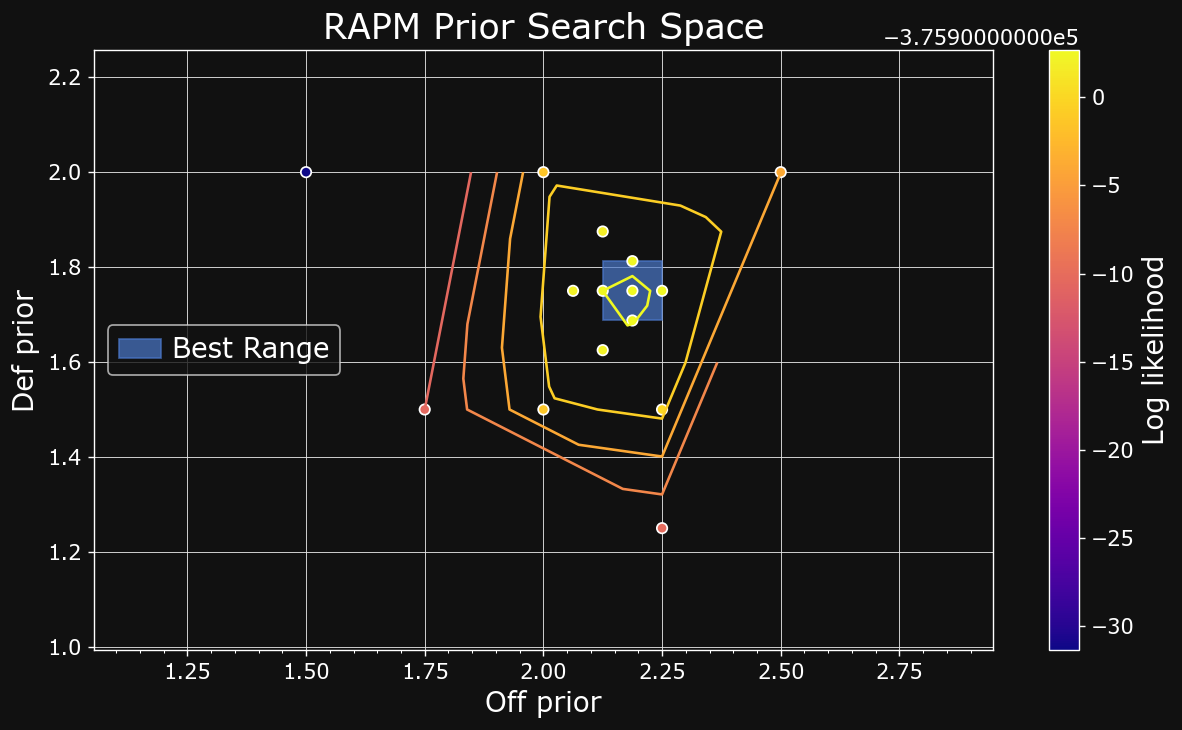

In [18]:
priors, scores = list(zip(*history))
sorted_scores = sorted(scores)
off_priors, def_priors = list(zip(*priors))
x_fill = [best_range[0, 0], best_range[0, 1], best_range[0, 1], best_range[0, 0]]
y_fill = [best_range[1, 0], best_range[1, 0], best_range[1, 1], best_range[1, 1]]
margin = 0.2
x_margin = min(off_priors) - margin, max(off_priors) + margin, max(off_priors) + margin, min(off_priors) - margin
y_margin = min(def_priors) - margin, min(def_priors) - margin, max(def_priors) + margin, max(def_priors) + margin

levels = np.linspace(sorted_scores[1], sorted_scores[-3], 5)
norm = Normalize(vmin=sorted_scores[0], vmax=sorted_scores[-1])
cmap = "plasma"
mappable = ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.fill(x_fill, y_fill, alpha=0.7, color="C0", label="Best Range")
ax.scatter(x=off_priors, y=def_priors, c=scores, norm=norm, cmap=cmap, edgecolors="w")
ax.plot(x_margin, y_margin, ".", mfc="None", mec="None")
ax.tricontour(off_priors, def_priors, scores, levels=levels, norm=norm, cmap=cmap)
ax.set_xlabel("Off prior")
ax.set_ylabel("Def prior")
ax.set_title(f"RAPM Prior Search Space")
ax.legend()
ax.axis("equal")
fig.colorbar(mappable, label="Log likelihood");

In [62]:
rapm = calc_rapm(possessions, *best_prior)

rapm.sort_values(by="rapm", ascending=False).head(30)

,name,rapm,off_rapm,def_rapm,rapm_std,off_rapm_std,def_rapm_std,off_poss,def_poss,raw_pm,off_raw_pm,def_raw_pm
201939,Stephen Curry,8.452059,6.807060,1.644998,1.594827,1.180841,1.072244,15771,15827,10.473969,8.089166,2.384802
203507,Giannis Antetokounmpo,7.305175,2.694255,4.610920,1.405318,1.030576,0.957760,21116,21169,9.392965,4.697111,4.695855
101108,Chris Paul,6.972867,3.886401,3.086465,1.310787,0.957067,0.897984,18883,18949,8.438974,6.045640,2.393333
2544,LeBron James,6.698153,5.460259,1.237894,1.307132,0.956361,0.894200,20204,20229,4.360857,3.372031,0.988826
203081,Damian Lillard,6.639017,6.006322,0.632695,1.442574,1.064223,0.980173,23549,23547,4.623514,5.798833,-1.175319
203999,Nikola Jokic,6.428381,5.283300,1.145081,1.571913,1.166682,1.058833,21597,21630,6.075763,6.460645,-0.384882
202695,Kawhi Leonard,6.346294,5.015268,1.331026,1.514824,1.112443,1.030308,12069,12070,10.730547,8.447390,2.283158
201950,Jrue Holiday,6.176063,4.240207,1.935857,1.305709,0.955009,0.893346,21909,21929,5.078448,4.004824,1.073623
203954,Joel Embiid,6.095409,2.107145,3.988264,1.462960,1.076526,0.994739,16532,16557,8.227216,3.461653,4.765563
202331,Paul George,6.038275,2.592757,3.445518,1.370211,1.001910,0.933997,20642,20628,6.870208,3.695040,3.175168


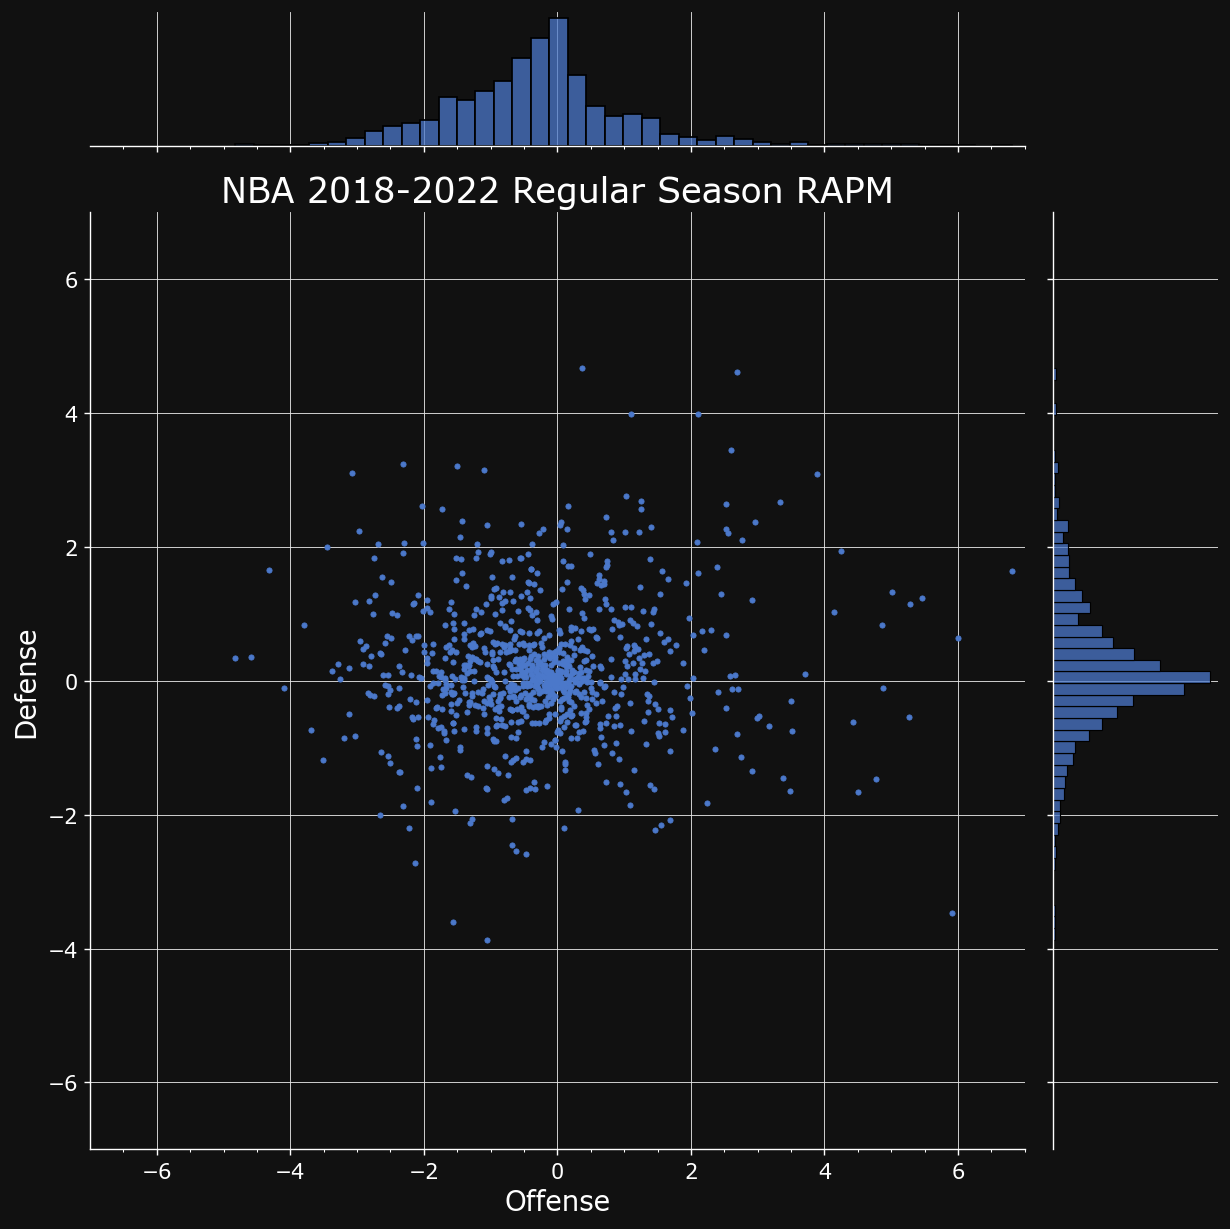

In [63]:
lim = max(np.ceil(rapm["off_rapm"].abs().max()), np.ceil(rapm["def_rapm"].abs().max()))
joint_grid = sns.jointplot(x=rapm["off_rapm"], y=rapm["def_rapm"], height=10, xlim=(-lim, lim), ylim=(-lim, lim), marker=".", edgecolor="C0");
joint_grid.ax_joint.set_xlabel("Offense")
joint_grid.ax_joint.set_ylabel("Defense")
joint_grid.ax_joint.set_title(f"{league.upper()} {min(years)}-{max(years)} {season_type} RAPM");